# Community Detection
In this session we shall use a community detection algorithm to discover large community of similar nodes in the graph we constructed in the earlier session "Finding pairwise dissimilarity from Siamese Network".

## Imports

In [1]:
!pip install markov_clustering[drawing]

In [0]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import PIL.ImageOps    
from PIL import Image
import numpy as np
import itertools
import math
import sys
import os
import markov_clustering as mc

## Helper functions

In [0]:
# Creates a NetworkX graph object
def make_graph(sim, labels=None):
    G = nx.Graph()
    for i in range(sim.shape[0]):
        for j in range(sim.shape[1]):
            if i != j and sim[i,j] != 0:
                if labels == None:
                    G.add_edge(i, j, weight=sim[i,j])
                else:
                    G.add_edge(labels[i], labels[j], weight=sim[i,j])
    return G

# Generate edges for Gephi or pals  
def export_edge_list(sim, labels=None, filename="edges.csv", delim=",", header=True):
    f = open(savedir + filename, 'w')
    if header:
        f.write("Source,Target\n")
    loc = np.where(sim > 0)
    for (i, j) in [(i, j) for (i, j) in zip(loc[0], loc[1]) if i < j]:
        if labels == None:
            f.write(str(i) + delim + str(j) + "\n")
        else:
            f.write("\"" + labels[i] + "\"" + delim + "\"" + labels[j] + "\"\n")                          
    f.close()
    
# Calculate Modularity
def Q1(comm,G):

   #边的个数

   edges=G.edges()

   m=len(edges)

   #print 'm',m



   #每个节点的度

   du=G.degree()

   #print 'du',du



   #通过节点对（同一个社区内的节点对）计算

   ret=0.0

   for c in comm:

       for x in c:

           for y in c:

               #边都是前小后大的

               #不能交换x，y，因为都是循环变量

               if x<=y:

                   if (x,y) in edges:

                       aij=1.0

                   else:

                       aij=0.0

               else:

                   if (y,x) in edges:

                       aij=1.0
                   else:
                       aij=0

               #print x,' ',y,' ',aij

               tmp=aij-du[x]*du[y]*1.0/(2*m)

               #print du[x],' ',du[y]

               #print tmp

               ret=ret+tmp

               #print ret

               #print ' '

               

   ret=ret*1.0/(2*m)

   #print 'ret ',ret

   return ret

##Configuration

In [0]:
class Config():
    colors = ['aquamarine', 'bisque', 'blanchedalmond', 'blueviolet', 'brown',
              'burlywood', 'cadetblue', 'chartreuse','chocolate', 'coral',
              'cornflowerblue', 'cornsilk', 'crimson', 'darkblue', 'darkcyan',
              'darkgoldenrod', 'darkgray', 'darkgreen', 'darkgrey', 'darkkhaki',
              'darkmagenta', 'darkolivegreen', 'darkorange', 'darkslateblue',
              'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
              'darkslategray', 'darkslategrey', 'darkturquoise', 'darkviolet',
              'deeppink', 'deepskyblue', 'dimgray', 'dimgrey', 'dodgerblue',
              'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro',
              'ghostwhite', 'gold', 'goldenrod', 'gray', 'green', 'greenyellow',
              'grey', 'honeydew', 'hotpink', 'indianred', 'indigo', 'ivory']

## Give access to Google Drive

In [5]:
savedir = ""
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/gdrive')
    savedir = "/content/gdrive/My Drive/calligraphy47new/"
    try:
        os.mkdir(savedir)
    except FileExistsError:
        print("Directory \"%s\" already exists" % (savedir))

print("Content of {}:".format(savedir))
os.listdir(savedir)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Directory "/content/gdrive/My Drive/calligraphy47new/" already exists
Content of /content/gdrive/My Drive/calligraphy47new/:


['labels.txt',
 'sim.txt',
 'pals-community.txt',
 'siamese.24.pth',
 'siamese.0.pth',
 'gephi-edges.csv',
 'pals-edges.txt',
 'Louvain_CD.txt']

## Build graph
Construct an adjacency matrix from the dissimilarity matrix, then use the adjacency matrix to build a networkx graph


In [6]:
# Loads the dissimilarity matrix (and node labels)

sim = np.loadtxt(savedir + 'sim.txt')
labels = list(np.genfromtxt(savedir + 'labels.txt', dtype='str'))

print("Restored %dx%d matrix" % (sim.shape[0], sim.shape[1]))
print("Labels of elements:", labels)

Restored 47x47 matrix
Labels of elements: ['c_h_zz', 'c_j_wxz', 'c_jd_mzd', 'c_m_wd', 'c_m_wzm', 'c_m_xw', 'c_m_zd', 'c_m_zym', 'c_m_zzs', 'c_q_zbq', 'cl_h_sxk', 'cl_h_wb', 'cl_q_dsr', 'cl_q_hsj', 'cl_q_jn', 'cl_q_zbq', 'cl_s_cy', 'cl_s_zmf', 'cl_t_llj', 'r_h_zy', 'r_j_wxz', 'r_m_ty', 'r_m_wzm', 'r_s_cx', 'r_s_mf', 'r_s_zj', 'r_s_zmf', 'r_t_csl', 'r_t_lgq', 's_h_xs', 's_q_dsr', 's_q_wrz', 's_q_wz', 's_q_ybs', 's_q_yys', 's_q_zzq', 's_qin_ls', 'sc_m_xw', 'sc_m_zd', 'sc_m_zzs', 'sc_q_kyw', 'sc_q_ly', 'sc_q_zbq', 'sc_s_cj', 'sc_s_cx', 'sc_s_htj', 'sc_s_mf']


diagonal avg=190.19 min=138.72 max=222.63


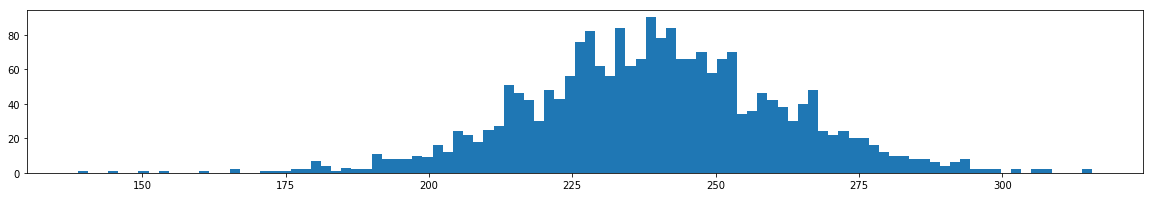

In [7]:
# Analyze distribution of dissimilarity score

d = np.diagonal(sim)
print('diagonal avg=%.2f min=%.2f max=%.2f' % (np.mean(d), np.min(d), np.max(d)))
simflat = sim.reshape((-1,))
plt.rcParams["figure.figsize"] = (20,3)
_ = plt.hist(simflat, bins=100)
plt.show()

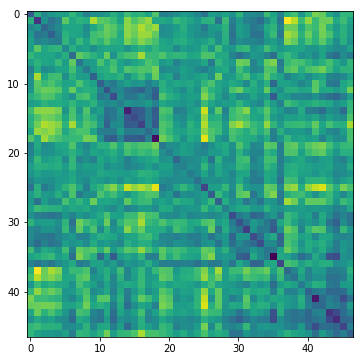

In [8]:
# View an image representation of the distance matrix

plt.figure(figsize=(6,6))
plt.imshow(sim)
plt.show()

In [9]:
# Select a suitable threshold and set dissimilarity scores larger than that threshold to zero

threshold = 223 #206
adjmat = sim.reshape((-1,)).copy()
adjmat[adjmat > threshold] = 0
#adjmat[adjmat > 0] = 1
print("{} out of {} values set to zero".format(len(adjmat[adjmat == 0]), len(adjmat)))
adjmat = adjmat.reshape(sim.shape)
# print(len(sim))

1734 out of 2209 values set to zero


In [0]:
# threshold=200
# nodes=0
# while(nodes<len(sim)):
#   threshold+=1
#   adjmat=sim.copy()
#   adjmat=adjmat.reshape((-1,))
#   adjmat[adjmat>threshold]=0
#   adjmat = adjmat.reshape(sim.shape)
#   G = make_graph(adjmat, labels=labels)
#   nodes=G.number_of_nodes();
# print("The threshold can be set to a value at or above %.1f"%threshold)

47
214


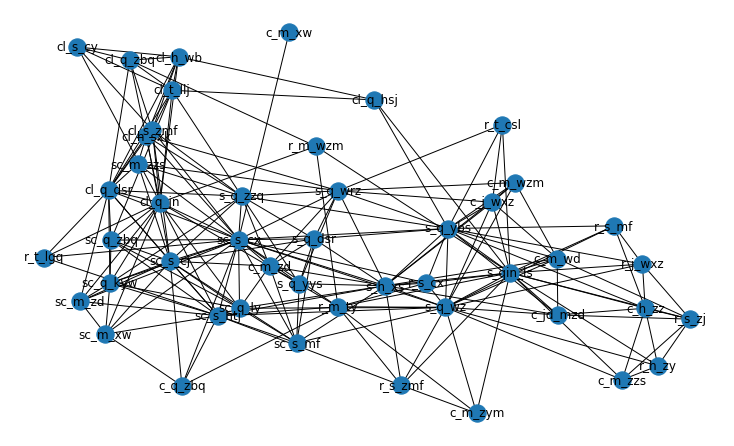

In [10]:
# Construct a networkx graph from the adjacency matrix
# (Singleton nodes are excluded from the graph)
G = make_graph(adjmat, labels=labels)
plt.rcParams["figure.figsize"] = (10, 6)
nx.draw(G, with_labels=True)
print(G.number_of_nodes())
print(G.number_of_edges())
# print(G)



#Louvain Community Detection

4.0
['c_h_zz', 'c_jd_mzd', 'c_m_zzs', 'r_h_zy', 'r_j_wxz', 'r_s_mf', 'r_s_zj', 's_q_ybs', 's_qin_ls', 'c_j_wxz', 'c_m_wd', 'c_m_wzm', 'r_t_csl', 's_q_wz', 'c_m_zym', 'r_m_ty', 'r_s_zmf', 'r_m_wzm', 'r_s_cx']
19
['s_h_xs', 's_q_wrz', 'c_m_zd', 's_q_dsr', 's_q_yys', 's_q_zzq', 'sc_s_mf']
7
['c_m_xw', 'sc_s_cx', 'sc_q_ly', 'sc_s_cj', 'c_q_zbq', 'sc_m_xw', 'sc_s_htj', 'cl_q_dsr', 'sc_m_zzs', 'cl_q_jn', 'r_t_lgq', 'sc_m_zd', 'sc_q_kyw', 'sc_q_zbq']
14
['cl_h_sxk', 'cl_h_wb', 'cl_s_zmf', 'cl_q_hsj', 'cl_q_zbq', 'cl_s_cy', 'cl_t_llj']
7


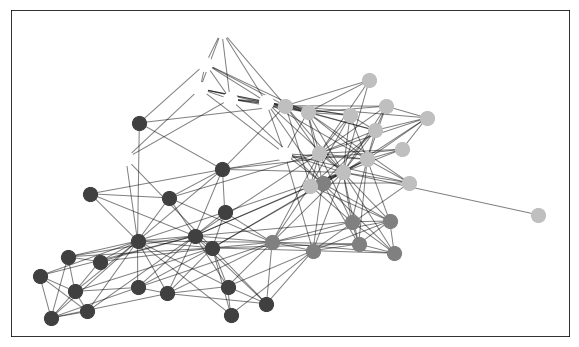

In [11]:
!pip install python-louvain
import community
import networkx as nx
import matplotlib.pyplot as plt

partition = community.best_partition(G)

#drawing
size = float(len(set(partition.values())))
print(size)
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
  f = open(savedir + 'Louvain_CD.txt', 'a')
  count = count + 1.
  list_nodes = [nodes for nodes in partition.keys()
                              if partition[nodes] == com]
  print(list_nodes)
  for node in list_nodes:
    f.write(str(node) + " " + str(count) + "\n")
  f.close()
  print(len(list_nodes))
  nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 200,
                              node_color = str(count / size))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

#Markov Clustering

[(0, 2, 3, 7, 8, 19, 20, 24, 25, 36), (1, 4, 33), (5, 6, 9, 10, 28, 30, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46), (11,), (12, 16), (13,), (14, 15), (17,), (18,), (21,), (22,), (23, 26, 32), (27, 29), (31,)]
14


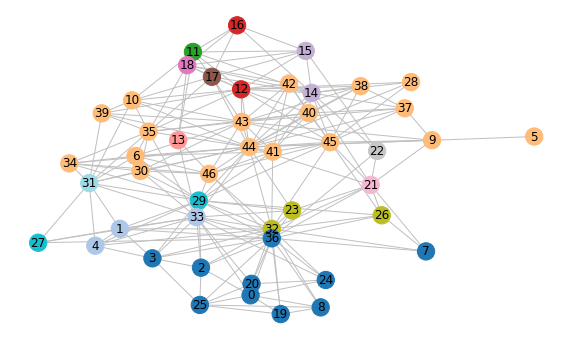

14
c_h_zz 1
c_jd_mzd 1
c_m_wd 1
c_m_zym 1
c_m_zzs 1
r_h_zy 1
r_j_wxz 1
r_s_mf 1
r_s_zj 1
s_qin_ls 1
c_j_wxz 2
c_m_wzm 2
s_q_ybs 2
c_m_xw 3
c_m_zd 3
c_q_zbq 3
cl_h_sxk 3
r_t_lgq 3
s_q_dsr 3
s_q_yys 3
s_q_zzq 3
sc_m_xw 3
sc_m_zd 3
sc_m_zzs 3
sc_q_kyw 3
sc_q_ly 3
sc_q_zbq 3
sc_s_cj 3
sc_s_cx 3
sc_s_htj 3
sc_s_mf 3
cl_h_wb 4
cl_q_dsr 5
cl_s_cy 5
cl_q_hsj 6
cl_q_jn 7
cl_q_zbq 7
cl_s_zmf 8
cl_t_llj 9
r_m_ty 10
r_m_wzm 11
r_s_cx 12
r_s_zmf 12
s_q_wz 12
r_t_csl 13
s_h_xs 13
s_q_wrz 14
0.2055528867149971


In [15]:
# markov_clustering method
# matrix = nx.to_scipy_sparse_matrix(G)
result = mc.run_mcl(adjmat,inflation=4.5)           # run MCL with default parameters
clusters = mc.get_clusters(result)    # get clusters
print(clusters)
print(len(clusters))
communities = []
for cluster in clusters:
  temp = []
  for i in cluster:
    temp.append(labels[i])
  communities.append(temp)
mc.draw_graph(adjmat, clusters, with_labels=True, edge_color="silver")
print(len(communities))
count = 0
for i in range(0,len(communities)):
  count += 1
  f=open(savedir + 'Markov_Clustering.txt', 'a')
  for node in communities[i]:
    print(node, count)
    f.write(node + " " + str(count) + "\n")
  f.close()
  
#modularity
print(Q1(communities,G))

In [0]:
# values = []
# for i in range(15, 26):
#   values.append(i)
# print(values)
# for inflation in values:
#   inflation = inflation / 10
#   result = mc.run_mcl(adjmat, inflation=inflation)
#   clusters = mc.get_clusters(result)
#   Q = mc.modularity(adjmat, clusters)
#   print("inflation:%f"%inflation, "modularity:%f"%Q)
# value = []
# for i in range(15,26):
#   temp = i / 10
#   value.append(temp)
# print(value[0])
# for inflation in value:
#     result = mc.run_mcl(adjmat, inflation=inflation)
#     clusters = mc.get_clusters(result)
#     Q = mc.modularity(result, clusters=clusters)
#     print("inflation:", inflation, "modularity:", Q)

#K - Clique Communities Detection

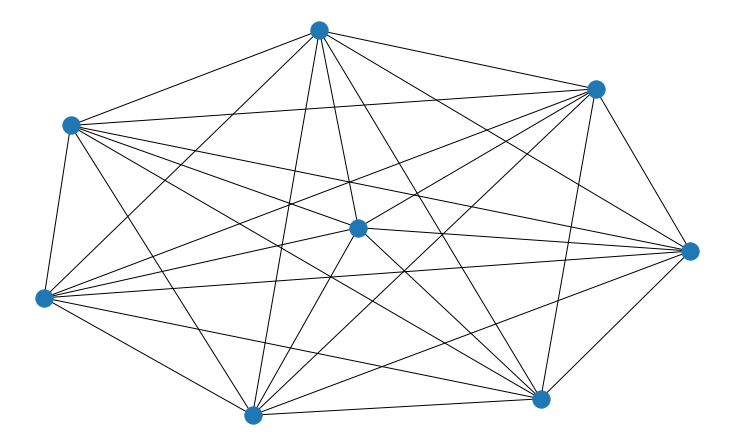

In [0]:
# from networkx import k_clique_communities
G0 = nx.complete_graph(8)
K5 = nx.convert_node_labels_to_integers(G0,first_label=2)
nx.draw(K5)
G0.add_edges_from(K5.edges())
# c = list(nx.k_clique_communities(G0, 4))
# list(c[0])
# list(nx.k_clique_communities(G0, 6))

#Community detection using Girvan-Newman

In [13]:
from networkx.algorithms.community.centrality import girvan_newman

comp = girvan_newman(G)

max_shown = 10
shown_count = 1
possibilities = []
for communities in itertools.islice(comp, max_shown):
    print("Possible clusters", shown_count, ": ", end='')
    print(communities)
    possibilities.append(communities)
    color_map = ["" for x in range(len(G))]
    color = 0
    for c in communities:
        indices = [i for i, x in enumerate(G.nodes) if x in c]
        for i in indices:
            color_map[i] = Config.colors[color]
        color += 1
    shown_count += 1
    nx.draw(G, node_color=color_map, with_labels=True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

#Visualization

###Gephi
Gephi Download - https://gephi.org/users/download/<br>
Gephi HOWTO    - https://gephi.wordpress.com/2017/09/26/gephi-0-9-2-a-new-csv-importer/<br>
*(It is possible to colorize communities in Gephi - read here: https://github.com/kalngyk/repoman/raw/master/gephi_communities.pdf)*


In [0]:
# Generate edges for Gephi

export_edge_list(adjmat, labels=labels, filename='gephi-edges.csv')

###pals
pals HOWTO - https://github.com/kalngyk/repoman/raw/master/usepals.pdf


In [0]:
# Generate edges for pals system

export_edge_list(adjmat, labels=labels, filename='pals-edges.txt', delim=" ", header=False)

In [0]:
# Generate community file for pals system

for i in range(1,max_shown+1):
  communities = possibilities[i-1]
  f = open(savedir + 'pals-community{}.txt'.format(i), 'w')
  cur_com = 1
  for c in communities:
      indices = [i for i, x in enumerate(G.nodes) if x in c]
      for i in indices:
          if labels == None:
              f.write(str(i) + " " + str(cur_com) + "\n")
          else:
              f.write("\"" + labels[i] + "\" " + str(cur_com) + "\n")
      cur_com += 1
  f.close()


# which_possibility = 8

# communities = possibilities[which_possibility-1]

# f = open(savedir + 'pals-community.txt', 'w')
# cur_com = 1
# for c in communities:
#     indices = [i for i, x in enumerate(G.nodes) if x in c]
#     for i in indices:
#         if labels == None:
#             f.write(str(i) + " " + str(cur_com) + "\n")
#         else:
#             f.write("\"" + labels[i] + "\" " + str(cur_com) + "\n")
#     cur_com += 1
# f.close()

# os.listdir(savedir)